This is the cleaned notebook with all the code that worked

In [57]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.lines as mlines
from shapely.geometry import Point, LineString
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm, colors
import matplotlib.patches as mpatches

## Step 1: Prepare Dataset
Add a column difference
Every dataset will have COUNTRY OF INTEREST. 

- Difference = positive --> There is more people coming INTO the country
- Difference = negative --> There is more peopel LEAVING the country. 

In [3]:
both_gender = pd.read_csv('data/both_gender.csv')
## Change the datatype of numerical column
both_gender['1960'] = pd.to_numeric(both_gender['1960'], errors='coerce').fillna(0).astype(int)
both_gender['1970'] = pd.to_numeric(both_gender['1970'], errors='coerce').fillna(0).astype(int)
both_gender['1980'] = pd.to_numeric(both_gender['1980'], errors='coerce').fillna(0).astype(int)
both_gender['1990'] = pd.to_numeric(both_gender['1990'], errors='coerce').fillna(0).astype(int)
both_gender['2000'] = pd.to_numeric(both_gender['2000'], errors='coerce').fillna(0).astype(int)
both_gender.columns = ["Origin_name",	"Origin_code", 	"Gender_Code",	"Destination_name",	"Destination_code",	"1960",	"1970",	"1980",	"1990",	"2000"]
both_gender

,Origin_name,Origin_code,Gender_Code,Destination_name,Destination_code,1960,1970,1980,1990,2000
0,Afghanistan,AFG,TOT,Afghanistan,AFG,0,0,0,0,0
1,Afghanistan,AFG,TOT,Albania,ALB,0,0,0,0,0
2,Afghanistan,AFG,TOT,Algeria,DZA,41,16,13,10,8
3,Afghanistan,AFG,TOT,American Samoa,ASM,0,0,0,0,0
4,Afghanistan,AFG,TOT,Andorra,AND,0,0,2,5,6
...,...,...,...,...,...,...,...,...,...,...
53587,Zimbabwe,ZWE,TOT,Wallis and Futuna,WLF,0,0,0,0,0
53588,Zimbabwe,ZWE,TOT,West Bank and Gaza,PSE,0,0,0,0,0
53589,Zimbabwe,ZWE,TOT,"Yemen, Rep.",YEM,0,0,0,0,0
53590,Zimbabwe,ZWE,TOT,Zambia,ZMB,90416,72452,49691,34855,31538


In [4]:
## Merge dataframe to get origin-->destination and destination-->origin
both_gender_bothway = both_gender.merge(both_gender, left_on = 'Destination_code', right_on = 'Origin_code')
both_gender_bothway = both_gender_bothway[both_gender_bothway['Origin_code_x'] == both_gender_bothway['Destination_code_y']]
both_gender_bothway = both_gender_bothway[both_gender_bothway['Origin_code_x'] != both_gender_bothway['Origin_code_y']]
both_gender_bothway

,Origin_name_x,Origin_code_x,Gender_Code_x,Destination_name_x,Destination_code_x,1960_x,1970_x,1980_x,1990_x,2000_x,Origin_name_y,Origin_code_y,Gender_Code_y,Destination_name_y,Destination_code_y,1960_y,1970_y,1980_y,1990_y,2000_y
231,Afghanistan,AFG,TOT,Albania,ALB,0,0,0,0,0,Albania,ALB,TOT,Afghanistan,AFG,0,0,0,3,0
462,Afghanistan,AFG,TOT,Algeria,DZA,41,16,13,10,8,Algeria,DZA,TOT,Afghanistan,AFG,7,30,17,33,54
693,Afghanistan,AFG,TOT,American Samoa,ASM,0,0,0,0,0,American Samoa,ASM,TOT,Afghanistan,AFG,0,0,0,1,0
924,Afghanistan,AFG,TOT,Andorra,AND,0,0,2,5,6,Andorra,AND,TOT,Afghanistan,AFG,0,0,0,0,0
1155,Afghanistan,AFG,TOT,Angola,AGO,0,0,0,0,0,Angola,AGO,TOT,Afghanistan,AFG,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,TOT,"Virgin Islands, British",VGB,0,0,0,0,0,"Virgin Islands, British",VGB,TOT,Zimbabwe,ZWE,0,0,0,0,0
12378827,Zimbabwe,ZWE,TOT,Wallis and Futuna,WLF,0,0,0,0,0,Wallis and Futuna,WLF,TOT,Zimbabwe,ZWE,0,0,0,0,0
12379058,Zimbabwe,ZWE,TOT,West Bank and Gaza,PSE,0,0,0,0,0,West Bank and Gaza,PSE,TOT,Zimbabwe,ZWE,2,2,2,2,2
12379289,Zimbabwe,ZWE,TOT,"Yemen, Rep.",YEM,0,0,0,0,0,"Yemen, Rep.",YEM,TOT,Zimbabwe,ZWE,1,2,2,2,1


In [5]:
## Get relevant columns and rename them
both_gender_bothway = both_gender_bothway[['Origin_name_x', 'Origin_code_x', 'Destination_name_x', 'Destination_code_x', 'Destination_name_y', 'Destination_code_y', '1960_x', '1970_x', '1980_x', '1990_x', '2000_x', '1960_y', '1970_y', '1980_y', '1990_y', '2000_y' ]]
both_gender_bothway.columns = ['Country_interest', 'Country_interest_code', 'Intermediate_country', 'Intermediate_country_code', 'Destination_name_y', 'Destination_code_y', '1960_leave', '1970_leave', '1980_leave', '1990_leave', '2000_leave', '1960_into', '1970_into', '1980_into', '1990_into', '2000_into' ]
both_gender_bothway

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,2000_leave,1960_into,1970_into,1980_into,1990_into,2000_into
231,Afghanistan,AFG,Albania,ALB,Afghanistan,AFG,0,0,0,0,0,0,0,0,3,0
462,Afghanistan,AFG,Algeria,DZA,Afghanistan,AFG,41,16,13,10,8,7,30,17,33,54
693,Afghanistan,AFG,American Samoa,ASM,Afghanistan,AFG,0,0,0,0,0,0,0,0,1,0
924,Afghanistan,AFG,Andorra,AND,Afghanistan,AFG,0,0,2,5,6,0,0,0,0,0
1155,Afghanistan,AFG,Angola,AGO,Afghanistan,AFG,0,0,0,0,0,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,"Virgin Islands, British",VGB,Zimbabwe,ZWE,0,0,0,0,0,0,0,0,0,0
12378827,Zimbabwe,ZWE,Wallis and Futuna,WLF,Zimbabwe,ZWE,0,0,0,0,0,0,0,0,0,0
12379058,Zimbabwe,ZWE,West Bank and Gaza,PSE,Zimbabwe,ZWE,0,0,0,0,0,2,2,2,2,2
12379289,Zimbabwe,ZWE,"Yemen, Rep.",YEM,Zimbabwe,ZWE,0,0,0,0,0,1,2,2,2,1


In [6]:
## Create the distnace column  (peopel coming in - people leaving coutry of interest)
both_gender_bothway['1960_difference'] = both_gender_bothway['1960_into'].sub(both_gender_bothway['1960_leave'], fill_value=0)
both_gender_bothway['1970_difference'] = both_gender_bothway['1970_into'] - both_gender_bothway['1970_leave']
both_gender_bothway['1980_difference'] = both_gender_bothway['1980_into'] - both_gender_bothway['1980_leave']
both_gender_bothway['1990_difference'] = both_gender_bothway['1990_into'] - both_gender_bothway['1990_leave']
both_gender_bothway['2000_difference'] = both_gender_bothway['2000_into'] - both_gender_bothway['2000_leave']
both_gender_bothway

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\2342366853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_gender_bothway['1960_difference'] = both_gender_bothway['1960_into'].sub(both_gender_bothway['1960_leave'], fill_value=0)
C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\2342366853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_gender_bothway['1970_difference'] = both_gender_bothway['1970_into'] - both_gender_bothway['1970_leave']
C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\23

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,...,1960_into,1970_into,1980_into,1990_into,2000_into,1960_difference,1970_difference,1980_difference,1990_difference,2000_difference
231,Afghanistan,AFG,Albania,ALB,Afghanistan,AFG,0,0,0,0,...,0,0,0,3,0,0,0,0,3,0
462,Afghanistan,AFG,Algeria,DZA,Afghanistan,AFG,41,16,13,10,...,7,30,17,33,54,-34,14,4,23,46
693,Afghanistan,AFG,American Samoa,ASM,Afghanistan,AFG,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
924,Afghanistan,AFG,Andorra,AND,Afghanistan,AFG,0,0,2,5,...,0,0,0,0,0,0,0,-2,-5,-6
1155,Afghanistan,AFG,Angola,AGO,Afghanistan,AFG,0,0,0,0,...,0,4,2,4,7,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,"Virgin Islands, British",VGB,Zimbabwe,ZWE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12378827,Zimbabwe,ZWE,Wallis and Futuna,WLF,Zimbabwe,ZWE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12379058,Zimbabwe,ZWE,West Bank and Gaza,PSE,Zimbabwe,ZWE,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
12379289,Zimbabwe,ZWE,"Yemen, Rep.",YEM,Zimbabwe,ZWE,0,0,0,0,...,1,2,2,2,1,1,2,2,2,1


## Create a function to graph a undirected graph 
Graph based on differences

In [7]:
def visualize_map_undirected(original_df, country_code, country_name,time_column):
    country_code_df = original_df[original_df['Country_interest_code'] == country_code]

    # Load world map from GeoPandas
    # Assuming you have your migration graph already created (G is your directed graph)

    # Load the world map from a custom shapefile
    shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)

    # Make sure ISO codes match your dataset’s format
    # For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
    world['ADM0_A3'] = world['ADM0_A3'].str.upper()

    # Create a column with centroid geometry for each country polygon
    # This yields a Point geometry representing the centroid of the country
    world_proj = world.to_crs(epsg=3857)

    # 3. Calculate centroids in the projected CRS
    world_proj['centroid'] = world_proj.geometry.centroid

    # 4. Convert the centroids back to lat-lon
    #    We switch the GeoDataFrame to use the 'centroid' column as its geometry
    world_proj = world_proj.set_geometry('centroid')
    world_proj = world_proj.to_crs(epsg=4326)

    # 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
    #    You can store them back in the original 'world' GeoDataFrame if you like:
    world['centroid'] = world_proj.geometry
    # Approximate center of the contiguous US
    contig_us_center = Point(-98.58, 39.83)  # (lon, lat)

    # Override the centroid for the USA row
    world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center
    world.loc[world['ADM0_A3'] == 'CHN', 'centroid'] = Point(104.1954, 35.8617)

    ## For palestine, the code is encoded differently
    world['ADM0_A3'] = world['ADM0_A3'].replace('PSX', 'PSE')

    # 4.1: Merge df with world to get origin geometry
    df_merged = country_code_df.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Country_interest_code', 
        right_on='ADM0_A3', 
        how='left'
    )

    # Rename the centroid column to something like origin_centroid
    df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # 4.2: Merge again to get destination geometry
    df_merged = df_merged.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Intermediate_country_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    df_merged = df_merged[df_merged['origin_centroid'] != None]


    def create_linestring(row):
        # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
        orig_point = row['origin_centroid']
        dest_point = row['destination_centroid']
        
        # If either is NaN or missing, return None
        if pd.isnull(orig_point) or pd.isnull(dest_point):
            return None
        
        return LineString([orig_point, dest_point])

    df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

    # Drop rows where geometry is None
    df_merged = df_merged.dropna(subset=['geometry'])

    # Convert this DataFrame to a GeoDataFrame
    gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

    # 1. Create an 'edge_color' column: blue if negative, red otherwise
    gdf_edges['edge_color'] = gdf_edges[time_column].apply(
        lambda x: 'blue' if x < 0 else 'red'
    )

    # 2. Scale line widths by the absolute value of 1960_difference
    max_diff = gdf_edges[time_column].abs().max()
    scale_factor = 10.0 / max_diff  # tweak for desired thickness
    gdf_edges['edge_width'] = gdf_edges[time_column].abs() * scale_factor
    # print(df_merged.shape)



    # Plot setup
    fig, ax = plt.subplots(figsize=(15,10))

    # 6.1 Plot the world map
    world.plot(ax=ax, color='white', edgecolor='black')

    gdf_edges.plot(
        ax=ax,
        color=gdf_edges['edge_color'],
        linewidth=gdf_edges['edge_width'],
        alpha=0.7
    )

    # -- (Optional) ADD NODE MARKERS BELOW -- #
    # We gather all unique origin and destination points in a separate GeoDataFrame
    all_points = []

    # Extract origin points
    tmp_orig = df_merged[['Country_interest_code', 'origin_centroid']].drop_duplicates()
    tmp_orig = tmp_orig.rename(columns={
        'Country_interest_code': 'country_code',
        'origin_centroid': 'geometry'
    })
    all_points.append(tmp_orig)

    # Extract destination points
    tmp_dest = df_merged[['Intermediate_country_code', 'destination_centroid']].drop_duplicates()
    tmp_dest = tmp_dest.rename(columns={
        'Intermediate_country_code': 'country_code',
        'destination_centroid': 'geometry'
    })
    all_points.append(tmp_dest)

    # Concatenate origin & destination points, drop duplicates
    df_points = pd.concat(all_points).drop_duplicates('country_code')
    # print(df_points)

    # Make a GeoDataFrame
    gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

    # Finally, plot the points on top of the map and lines
    gdf_points.plot(
        ax=ax,
        color='green',
        markersize=30,  # Adjust as desired
        zorder=4        # Ensures markers appear above the lines
    )

    # Create custom legend handles
    red_line = mlines.Line2D([], [], color='red', linewidth=2, label='More immigration than emigration')
    blue_line = mlines.Line2D([], [], color='blue', linewidth=2, label='More emigration than immigration')

    # Add the legend to the plot (adjust loc as needed, e.g., 'upper right')
    plt.legend(handles=[red_line, blue_line], loc='lower left')

    plt.title(f"Net difference in migration at {country_name} ({country_code}) at year {time_column[:4]}")
    plt.show()


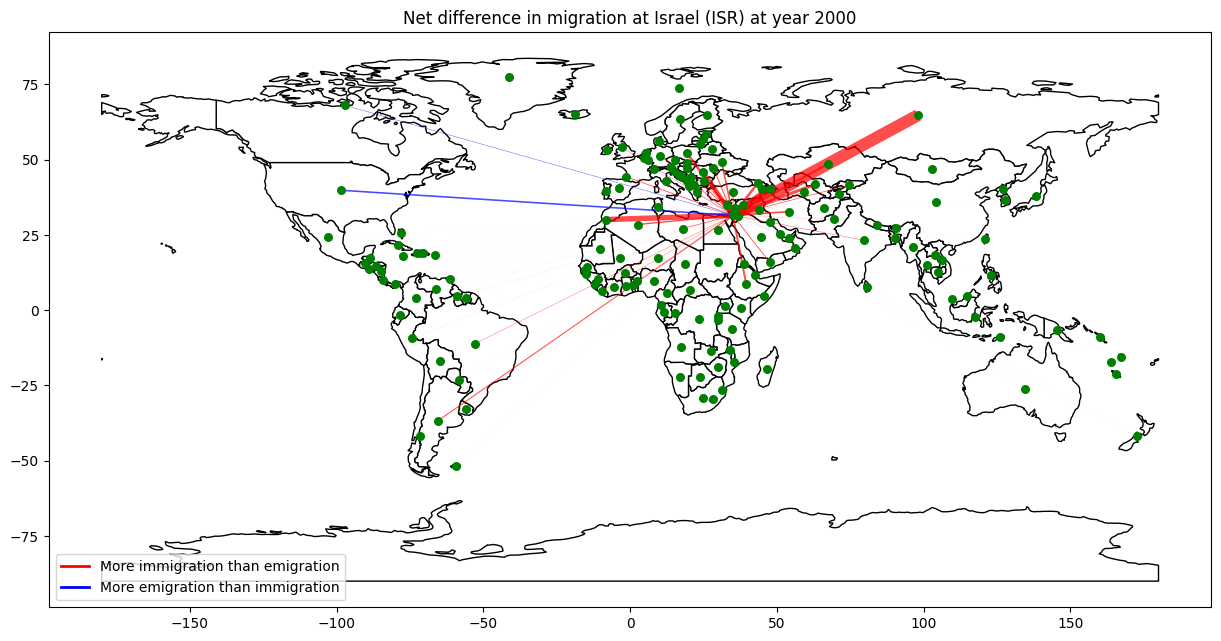

In [22]:
visualize_map_undirected(both_gender_bothway, 'ISR', 'Israel', '2000_difference')

## Code for moving into 

In [42]:
def visualize_map_directed_into(original_df, country_code, country_name,time_column):
    ## Make sure that time_column is "into" column
    if 'into' not in time_column:
        print('wrong column. This function utilize migration coming into {country_name}')
        return None
    
    # Filter rows so that the country of interest (destination) equals your specified country code.
    # (Assuming that the country of interest is stored in 'Country_interest_code')
    country_code_df = original_df[original_df['Country_interest_code'] == country_code]

    # 2. Load world map from a shapefile using GeoPandas
    shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)

    # Ensure the ISO codes are uppercase to match your dataset
    world['ADM0_A3'] = world['ADM0_A3'].str.upper()

    # 3. Create centroids for each country (in lat-lon)
    world_proj = world.to_crs(epsg=3857)
    world_proj['centroid'] = world_proj.geometry.centroid
    world_proj = world_proj.set_geometry('centroid').to_crs(epsg=4326)
    world['centroid'] = world_proj.geometry

    # Override the centroid for specific countries if desired
    contig_us_center = Point(-98.58, 39.83)  # approximate center of contiguous US
    world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center
    world.loc[world['ADM0_A3'] == 'CHN', 'centroid'] = Point(104.1954, 35.8617)
    world['ADM0_A3'] = world['ADM0_A3'].replace('PSX', 'PSE')

    # 4. Merge to obtain geometry information
    # 4.1: Merge with the world map to get the origin geometry (from the intermediate country)
    df_merged = country_code_df.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Intermediate_country_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # 4.2: Merge again to get the destination geometry (the country of interest)
    df_merged = df_merged.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Country_interest_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # Drop rows with missing origin geometry if any
    df_merged = df_merged[df_merged['origin_centroid'].notnull()]

    # 5. Create a linestring from the intermediate (origin) to the country of interest (destination)
    def create_linestring(row):
        orig_point = row['origin_centroid']
        dest_point = row['destination_centroid']
        if pd.isnull(orig_point) or pd.isnull(dest_point):
            return None
        # Create a line from origin (intermediate) TO destination (country of interest)
        return LineString([orig_point, dest_point])

    df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)
    df_merged = df_merged.dropna(subset=['geometry'])

    # Convert the DataFrame to a GeoDataFrame
    gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

    # 6. Set up plotting and create a colormap for the time column values
    vmin = gdf_edges[time_column].min()
    vmax = gdf_edges[time_column].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap('Reds')

    fig, ax = plt.subplots(figsize=(15, 10))

    # 6.1 Plot the world map
    world.plot(ax=ax, color='white', edgecolor='black')

    # 6.2 Instead of plotting lines, add FancyArrowPatch arrows for each edge.
    for idx, row in gdf_edges.iterrows():
        line = row['geometry']
        # Extract start (origin) and end (destination) coordinates
        x0, y0 = line.coords[0]
        x1, y1 = line.coords[-1]
        
        # Color based on the value in the time_column using the colormap
        arrow_color = cmap(norm(row[time_column]))
        
        # Create an arrow from the origin to destination
        arrow = FancyArrowPatch(
            (x0, y0), (x1, y1),
            arrowstyle='-|>',   # arrow head style
            color=arrow_color,
            mutation_scale=10,  # scale of the arrow head
            lw=2,
            alpha=0.7
        )
        ax.add_patch(arrow)

    # (Optional) Add a colorbar for reference
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label=f"Country coming {time_column[-4:]} {country_code}", shrink = 0.5)

    # 6.3 (Optional) Plot node markers for destination and intermediate points
    all_points = []

    # Destination points (country of interest)
    tmp_dest = df_merged[['Country_interest_code', 'destination_centroid']].drop_duplicates()
    tmp_dest = tmp_dest.rename(columns={
        'Country_interest_code': 'country_code',
        'destination_centroid': 'geometry'
    })
    all_points.append(tmp_dest)

    # Origin points (intermediate countries)
    tmp_orig = df_merged[['Intermediate_country_code', 'origin_centroid']].drop_duplicates()
    tmp_orig = tmp_orig.rename(columns={
        'Intermediate_country_code': 'country_code',
        'origin_centroid': 'geometry'
    })
    all_points.append(tmp_orig)

    df_points = pd.concat(all_points).drop_duplicates('country_code')
    gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

    gdf_points.plot(
        ax=ax,
        color='green',
        markersize=30,  # adjust as desired
        zorder=4       # ensure markers are plotted on top
    )

    plt.title(f"Migration directed toward {country_name} ({country_code}) at year {time_column[:4]}")
    plt.show()
    

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\1835047064.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


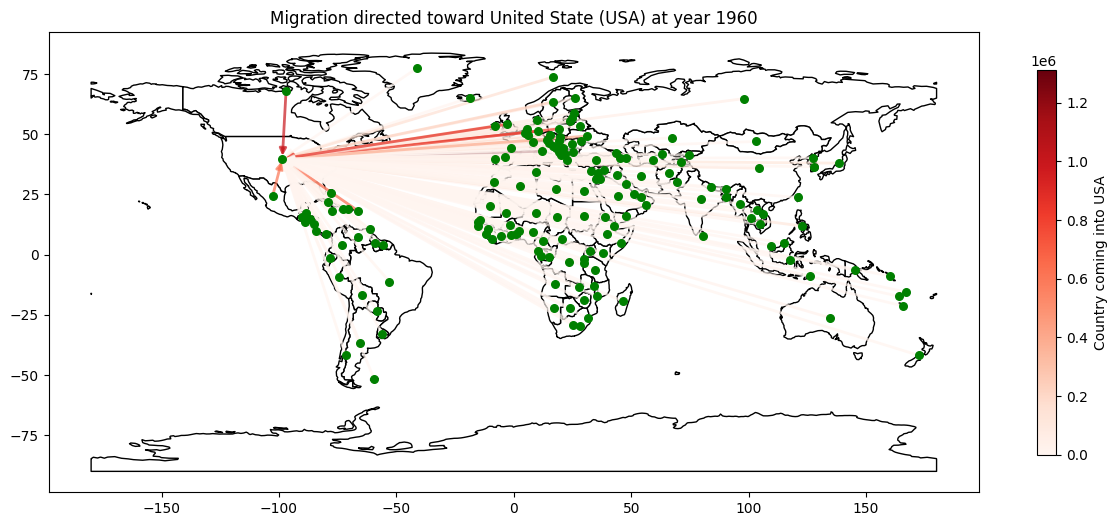

In [43]:
visualize_map_directed_into(both_gender_bothway, 'USA', 'United State', '1960_into')

## Code for leaving 

In [44]:
def visualize_map_directed_leave(original_df, country_code, country_name,time_column):
    if 'leave' not in time_column:
        print('wrong column. This function utilize migration leaving {country_name}')
        return None

    # Filter rows so that the country of interest (destination) equals your specified country code.
    # (Assuming that the country of interest is stored in 'Country_interest_code')
    country_code_df = original_df[original_df['Country_interest_code'] == country_code]

    # 2. Load world map from a shapefile using GeoPandas
    shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)

    # Ensure the ISO codes are uppercase to match your dataset
    world['ADM0_A3'] = world['ADM0_A3'].str.upper()

    # 3. Create centroids for each country (in lat-lon)
    world_proj = world.to_crs(epsg=3857)
    world_proj['centroid'] = world_proj.geometry.centroid
    world_proj = world_proj.set_geometry('centroid').to_crs(epsg=4326)
    world['centroid'] = world_proj.geometry

    # Override the centroid for specific countries if desired
    contig_us_center = Point(-98.58, 39.83)  # approximate center of contiguous US
    world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center
    world.loc[world['ADM0_A3'] == 'CHN', 'centroid'] = Point(104.1954, 35.8617)
    world['ADM0_A3'] = world['ADM0_A3'].replace('PSX', 'PSE')

    # 4. Merge to obtain geometry information
    # 4.1: Merge with the world map to get the origin geometry (from the intermediate country)
    df_merged = country_code_df.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Intermediate_country_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # 4.2: Merge again to get the destination geometry (the country of interest)
    df_merged = df_merged.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Country_interest_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # Drop rows with missing origin geometry if any
    df_merged = df_merged[df_merged['origin_centroid'].notnull()]

    # 5. Create a linestring from the intermediate (origin) to the country of interest (destination)
    def create_linestring(row):
        dest_point = row['origin_centroid']
        orig_point = row['destination_centroid']
        if pd.isnull(orig_point) or pd.isnull(dest_point):
            return None
        # Create a line from origin (intermediate) TO destination (country of interest)
        return LineString([orig_point, dest_point])

    df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)
    df_merged = df_merged.dropna(subset=['geometry'])

    # Convert the DataFrame to a GeoDataFrame
    gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

    # 6. Set up plotting and create a colormap for the time column values
    vmin = gdf_edges[time_column].min()
    vmax = gdf_edges[time_column].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap('Blues')

    fig, ax = plt.subplots(figsize=(15, 10))

    # 6.1 Plot the world map
    world.plot(ax=ax, color='white', edgecolor='black')

    # 6.2 Instead of plotting lines, add FancyArrowPatch arrows for each edge.
    for idx, row in gdf_edges.iterrows():
        line = row['geometry']
        # Extract start (origin) and end (destination) coordinates
        x0, y0 = line.coords[0]
        x1, y1 = line.coords[-1]
        
        # Color based on the value in the time_column using the colormap
        arrow_color = cmap(norm(row[time_column]))
        
        # Create an arrow from the origin to destination
        arrow = FancyArrowPatch(
            (x0, y0), (x1, y1),
            arrowstyle='-|>',   # arrow head style
            color=arrow_color,
            mutation_scale=10,  # scale of the arrow head
            lw=2,
            alpha=0.7
        )
        ax.add_patch(arrow)

    # (Optional) Add a colorbar for reference
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label=f"Population to {time_column[-5:]} {country_code}", shrink = 0.5)

    # 6.3 (Optional) Plot node markers for destination and intermediate points
    all_points = []

    # Destination points (country of interest)
    tmp_dest = df_merged[['Country_interest_code', 'destination_centroid']].drop_duplicates()
    tmp_dest = tmp_dest.rename(columns={
        'Country_interest_code': 'country_code',
        'destination_centroid': 'geometry'
    })
    all_points.append(tmp_dest)

    # Origin points (intermediate countries)
    tmp_orig = df_merged[['Intermediate_country_code', 'origin_centroid']].drop_duplicates()
    tmp_orig = tmp_orig.rename(columns={
        'Intermediate_country_code': 'country_code',
        'origin_centroid': 'geometry'
    })
    all_points.append(tmp_orig)

    df_points = pd.concat(all_points).drop_duplicates('country_code')
    gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

    gdf_points.plot(
        ax=ax,
        color='green',
        markersize=30,  # adjust as desired
        zorder=4       # ensure markers are plotted on top
    )

    plt.title(f"Migration directed out of {country_name} ({country_code}) at year {time_column[:4]}")
    plt.show()
    

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\3861369680.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


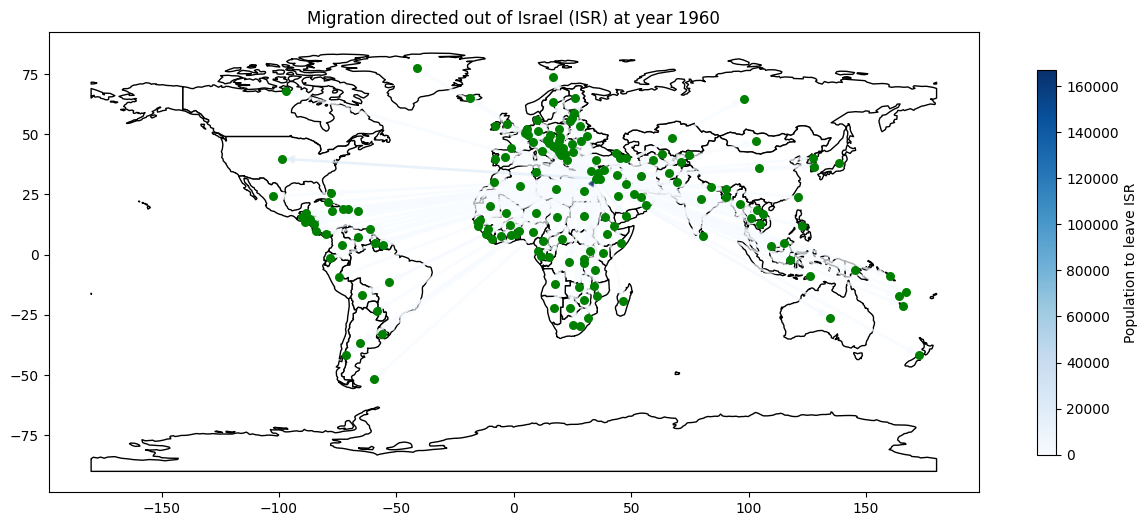

In [46]:
visualize_map_directed_leave(both_gender_bothway, 'ISR', 'Israel', '1960_leave')

## How about in and leave at the same time?

Very confusing. How about using difference column instead

In [58]:
def visualize_map_undirected_both(original_df, country_code, country_name,time_column):
    if 'difference' not in time_column:
        print('wrong column. This function utilize migration net difference {country_name}')
        return None
    
    # Filter rows so that the country of interest (destination) equals your specified country code.
    country_code_df = original_df[original_df['Country_interest_code'] == country_code]

    # 2. Load world map from a shapefile using GeoPandas
    shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)

    # Ensure the ISO codes are uppercase to match your dataset
    world['ADM0_A3'] = world['ADM0_A3'].str.upper()

    # 3. Create centroids for each country (in lat-lon)
    world_proj = world.to_crs(epsg=3857)
    world_proj['centroid'] = world_proj.geometry.centroid
    world_proj = world_proj.set_geometry('centroid').to_crs(epsg=4326)
    world['centroid'] = world_proj.geometry

    # Override the centroid for specific countries if desired
    contig_us_center = Point(-98.58, 39.83)  # approximate center of contiguous US
    world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center
    world.loc[world['ADM0_A3'] == 'CHN', 'centroid'] = Point(104.1954, 35.8617)
    world['ADM0_A3'] = world['ADM0_A3'].replace('PSX', 'PSE')

    # 4. Merge to obtain geometry information
    # 4.1: Merge to get the origin geometry from the intermediate country
    df_merged = country_code_df.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Intermediate_country_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # 4.2: Merge to get the destination geometry (country of interest, USA)
    df_merged = df_merged.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Country_interest_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # Drop rows with missing geometry if any
    df_merged = df_merged[df_merged['destination_centroid'].notnull() & df_merged['origin_centroid'].notnull()]

    # 5. Create a linestring from the country of interest (USA) to the intermediate country.
    #    This means the arrow will start at USA and point toward the intermediate country.
    def create_linestring(row):
        # print(row[time_column])
        if row[time_column] <= 0:
            start_point = row['destination_centroid']  # USA's centroid
            end_point = row['origin_centroid']           # Intermediate country's centroid
        else:
            end_point = row['destination_centroid']  # USA's centroid
            start_point = row['origin_centroid']           # Intermediate country's centroid
        if pd.isnull(start_point) or pd.isnull(end_point):
            return None
        return LineString([start_point, end_point])

    df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)
    df_merged = df_merged.dropna(subset=['geometry'])

    # Convert the DataFrame to a GeoDataFrame
    gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

    # 6. Set up plotting and create a colormap based on the "1960_difference" column
    # vmin = gdf_edges[time_column].min()
    # vmax = gdf_edges[time_column].max()
    # norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    # Compute the max absolute value so the color range is symmetric around zero
    abs_max = max(abs(gdf_edges[time_column].min()), abs(gdf_edges[time_column].max()))

    norm = colors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)


    cmap = cm.get_cmap('bwr')

    fig, ax = plt.subplots(figsize=(15, 10))

    # 6.1 Plot the world map
    world.plot(ax=ax, color='white', edgecolor='black')

    # 6.2 Loop through each edge and add an arrow using FancyArrowPatch.
    for idx, row in gdf_edges.iterrows():
        line = row['geometry']
        # Extract start and end coordinates
        x_start, y_start = line.coords[0]
        x_end, y_end = line.coords[-1]
        
        # Determine the arrow color based on the time column value
        arrow_color = cmap(norm(row[time_column]))
        
        arrow = FancyArrowPatch(
            (x_start, y_start), (x_end, y_end),
            arrowstyle='-|>',
            color=arrow_color,
            mutation_scale=10,
            lw=2,
            alpha=0.7
        )
        ax.add_patch(arrow)

    # (Optional) Add a colorbar with a smaller gradient legend
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label=f"{time_column}", shrink=0.5)

    # 6.3 (Optional) Plot node markers for destination and intermediate points
    all_points = []

    # Destination points (country of interest, USA)
    tmp_dest = df_merged[['Country_interest_code', 'destination_centroid']].drop_duplicates()
    tmp_dest = tmp_dest.rename(columns={
        'Country_interest_code': 'country_code',
        'destination_centroid': 'geometry'
    })
    all_points.append(tmp_dest)

    # Origin points (intermediate countries)
    tmp_orig = df_merged[['Intermediate_country_code', 'origin_centroid']].drop_duplicates()
    tmp_orig = tmp_orig.rename(columns={
        'Intermediate_country_code': 'country_code',
        'origin_centroid': 'geometry'
    })
    all_points.append(tmp_orig)

    df_points = pd.concat(all_points).drop_duplicates('country_code')
    gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

    gdf_points.plot(
        ax=ax,
        color='green',
        markersize=30,
        zorder=4
    )

    plt.title(f"Net Migration of {country_name} ({country_code}) at year {time_column[:4]}")


    blue_patch = mpatches.Patch(color='blue', label='Leaving (negative)')
    red_patch = mpatches.Patch(color='red', label='Moving in (positive)')

    ax.legend(
        handles=[blue_patch, red_patch], 
        loc='lower left',     # place at bottom-left
        framealpha=0.8        # slightly transparent
    )



    plt.show()

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\3328257817.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


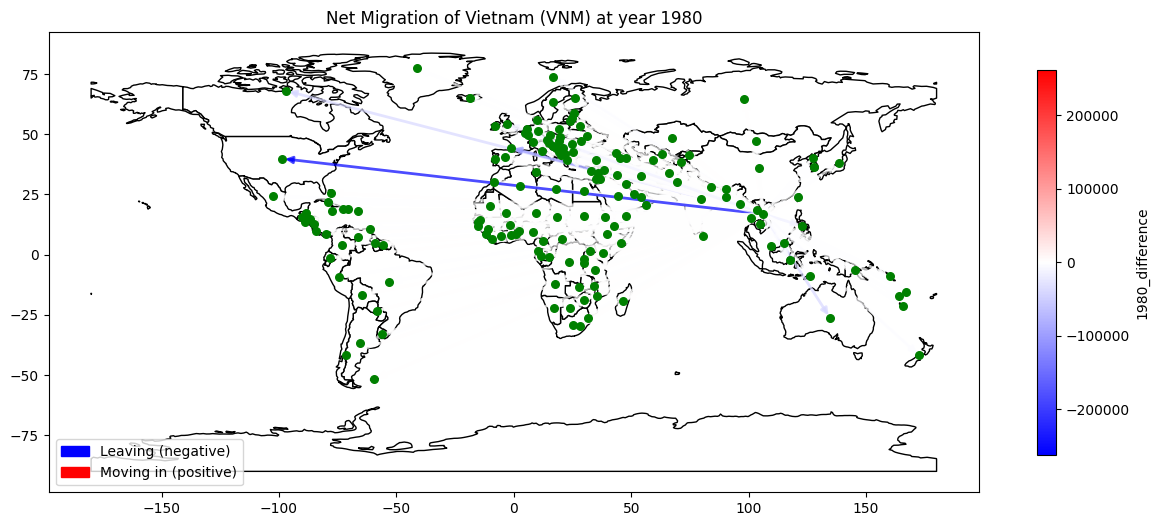

In [59]:
visualize_map_undirected_both(both_gender_bothway, 'VNM', 'Vietnam', '1980_difference')

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\3861369680.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


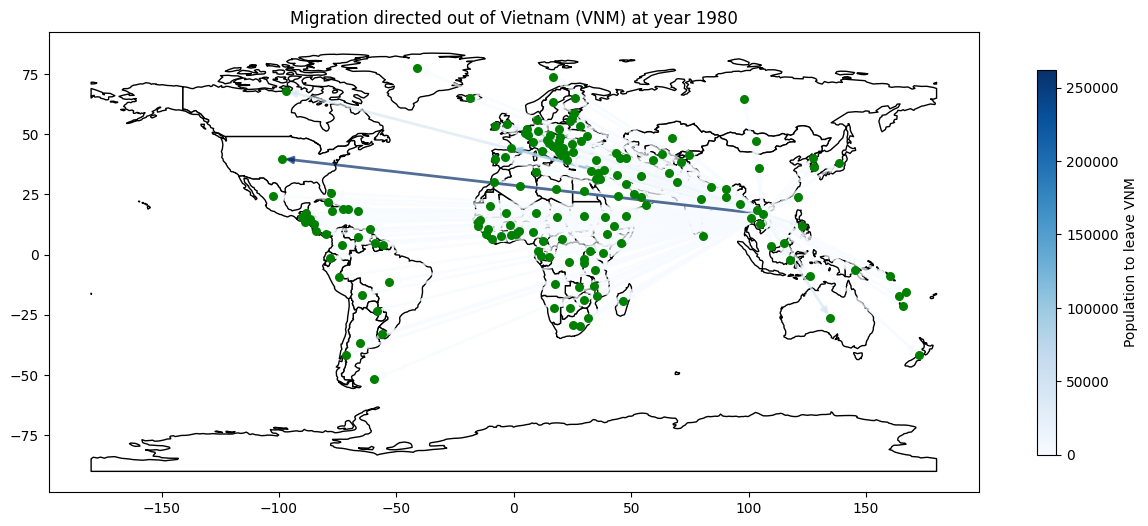

In [49]:
visualize_map_directed_leave(both_gender_bothway, 'VNM', 'Vietnam', '1980_leave')

C:\Users\Luna\AppData\Local\Temp\ipykernel_39388\1835047064.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


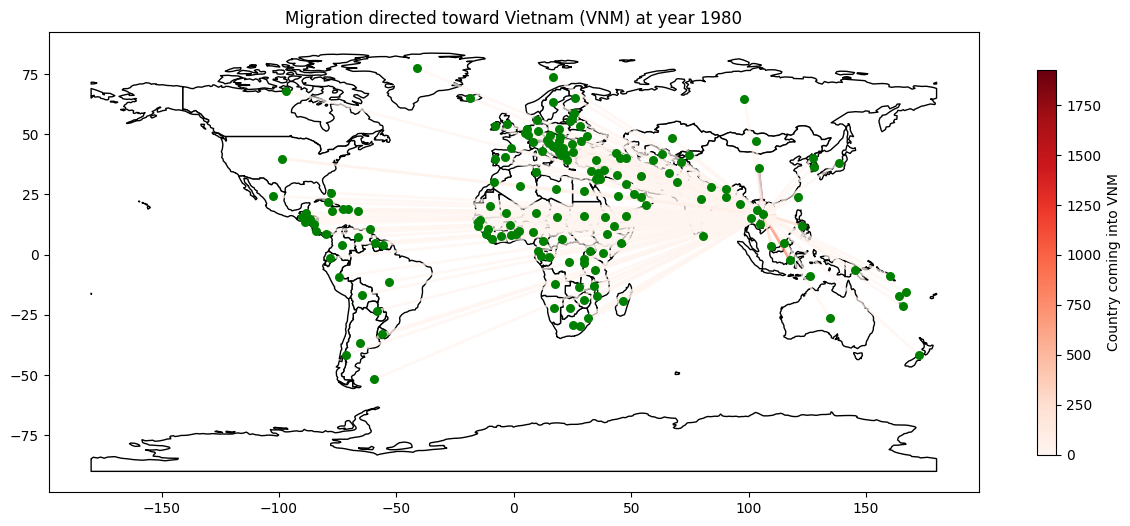

In [50]:
visualize_map_directed_into(both_gender_bothway, 'VNM', 'Vietnam', '1980_into')